In [181]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [182]:
c2w1 = np.array([0.34303784370422363,
                 -0.8594792485237122,
                 0.3789729177951813,
                 3.7897279262542725,
                 0.9393215775489807,
                 0.3138796091079712,
                 -0.13839992880821228,
                 -1.3840025663375854,
                 0.0,
                 0.40345385670661926,
                 0.9150000214576721,
                 9.149999618530273,
                 0.0,
                 0.0,
                 0.0,
                 1.0])
c2w1 = c2w1.reshape((4, 4))


c2w2 = np.array([-0.7053813934326172,
                -0.5776947736740112,
                0.41073814034461975,
                4.1073899269104,
                0.7088279724121094,
                -0.5748858451843262,
                0.4087409973144531,
                4.087401390075684,
                0.0,
                0.5794609785079956,
                0.8149999976158142,
                8.149999618530273,
                0.0,
                0.0,
                0.0,
                1.0])
c2w2 = c2w2.reshape((4, 4))

In [183]:
H = 400
W = 400
f = 1200

In [184]:
c2w = c2w1

In [185]:
rays_o = np.zeros((H*W, 3))
rays_d = np.zeros((H*W, 3))

In [186]:
u = np.arange(W)
v = np.arange(H)

In [187]:
u, v = np.meshgrid(u, v)

In [188]:
dirs = np.stack((u - W/2,
                 -(v - H/2),
                 -np.ones_like(u) * f), axis=-1)

dirs = (c2w[:3, :3] @ dirs[..., None]).squeeze(-1)
rays_d = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)
rays_d = rays_d.reshape(-1, 3)

rays_o +=c2w[:3, 3]

In [189]:
dirs.shape

(400, 400, 3)

In [190]:
def plot_rays(o, d, t):

  fig = plt.figure(figsize=(12, 12))
  ax = fig.add_subplot(projection = '3d')

  pt1 = o
  pt2 = o + d * t

  for p1, p2 in zip(pt1[::100], pt2[::100]):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]])

  plt.show()

In [191]:
# plot_rays(rays_o, rays_d, 1)

In [192]:
class Sphere():

  def __init__(self, p, r, c):
    self.p = p
    self.r = r
    self.c = c

  def intersect(self, x):
    """
    :param x: points[batch_size, 3]
    """

    cond = (x[:, 0] - self.p[0])**2 + (x[:, 1] - self.p[1])**2 + (x[:, 2] - self.p[2])**2 < self.r**2

    num_rays = x.shape[0]
    colors = torch.zeros((num_rays, 3))
    density = torch.zeros((num_rays, 1))

    colors[cond] = self.c
    density[cond] = 10

    color_condition = x[:, 0] < 0
    tmp = colors[color_condition, 0].clone()
    colors[color_condition, 0] = colors[color_condition, 1].clone()
    colors[color_condition, 1] = tmp

    return colors, density

In [193]:
s = Sphere(np.array([0, 0, -1]), 0.1, np.array([1, 0, 0]))

In [194]:
def compute_accumulated_transmittance(betas):
  accumulated_transmittance = torch.cumprod(betas, 1)
  # accumulated_transmittance[:, 1:] = accumulated_transmittance[:, :-1]
  # accumulated_transmittance[:, 0] = 1.0
  return torch.cat((torch.ones(accumulated_transmittance.shape[0], 1, device=accumulated_transmittance.device),
                    accumulated_transmittance[:, :-1]), dim=1)

In [195]:
def rendering(model, rays_o, rays_d, tn, tf, nb_bins=100, device="cpu"):

  t = torch.linspace(tn, tf, nb_bins).to(device)
  delta = torch.cat((t[1:] - t[:-1], torch.tensor([1e10])))

  x = rays_o.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * rays_d.unsqueeze(1)

  colors, density = model.intersect(x.reshape(-1, 3))

  colors = colors.reshape((x.shape[0], nb_bins, 3)) # [nb_bins, nb_bins, 3]
  density = density.reshape((x.shape[0], nb_bins))

  alpha = 1 - torch.exp(-density * delta.unsqueeze(0)) # [nb_bins, nb_bins, 1]
  T = compute_accumulated_transmittance(1 - alpha) # [nb_bins, nb_bins, 1]

  c = (T.unsqueeze(-1) * alpha.unsqueeze(-1) * colors).sum(1)

  return c

In [196]:
model = Sphere(torch.tensor([0, 0, 0]), 1, torch.tensor([1., 0., 0.]))
px_colors = rendering(model, torch.from_numpy(rays_o), torch.from_numpy(rays_d), 8, 12)

In [197]:
img = px_colors.reshape((H, W, 3)).cpu().numpy()

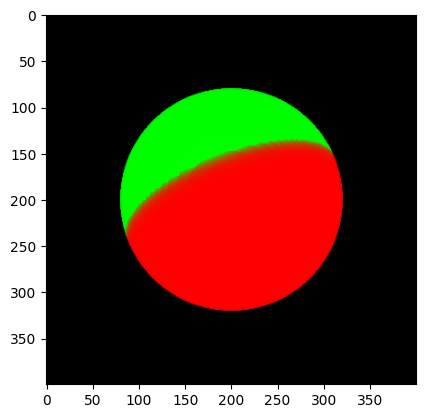

In [198]:
plt.figure(dpi=100)
plt.imshow(img)